# Ordinal Rating Prediction (1-5 Stars)
Direct implementation without function definitions

## 1. Setup and Data Generation

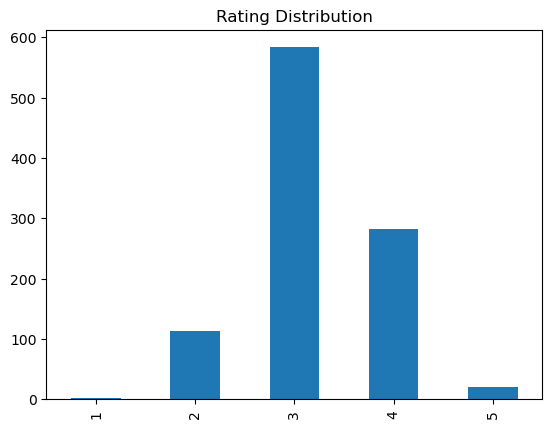

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from coral_pytorch.losses import coral_loss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.layers import CoralLayer

# Generate synthetic data
np.random.seed(42)
num_samples = 1000
features = np.random.rand(num_samples, 5)
weights = np.array([0.8, -0.5, 0.3, -0.2, 0.1])
ratings = np.clip(np.round(np.dot(features, weights) + 3 + np.random.normal(0, 0.5, num_samples)), 1, 5).astype(int)

# Show distribution
pd.Series(ratings).value_counts().sort_index().plot(kind='bar')
plt.title('Rating Distribution')
plt.show()

## 2. Data Preprocessing

In [2]:
# Normalize features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)
# Convert to tensors
X = torch.FloatTensor(normalized_features)
y = torch.LongTensor(ratings) - 1 #######This line # 0-based labels

print(f"Feature tensor shape: {X.shape}")
print(f"Rating tensor shape: {y.shape}")
print(y)

Feature tensor shape: torch.Size([1000, 5])
Rating tensor shape: torch.Size([1000])
tensor([2, 1, 2, 3, 3, 3, 2, 2, 2, 2, 4, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 2, 2,
        2, 1, 3, 3, 3, 1, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 4, 2, 2, 1, 2, 1, 3, 2,
        2, 2, 1, 2, 1, 2, 1, 2, 4, 2, 2, 2, 2, 3, 2, 3, 1, 2, 2, 2, 2, 1, 2, 3,
        2, 2, 2, 2, 2, 2, 4, 2, 1, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 3, 2, 3,
        2, 2, 2, 2, 1, 2, 3, 2, 3, 4, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2,
        2, 3, 1, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 3,
        3, 3, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 1, 2, 3, 3, 2, 2, 3, 3, 2, 2,
        2, 2, 2, 1, 3, 2, 2, 1, 2, 1, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 3, 3,
        2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 1, 1, 3, 2, 2, 3, 2, 3, 3, 2, 3, 2, 2, 2,
        2, 2, 3, 2, 2, 1, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 3, 2, 2, 4, 2, 2, 2,
        2, 2, 2, 2, 4, 2, 3, 2, 3, 2, 3, 1, 1, 2, 3, 1, 1, 3, 2, 2, 1, 2, 2, 2,
        3, 1, 2, 2, 2, 2, 3, 1, 3, 2

## 3. Model Definition

In [3]:
model = nn.Sequential(
    nn.Linear(5, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    CoralLayer(64, 5)  ##### this line # 5 ordinal classes
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## 4. Training

In [4]:
batch_size = 32
for epoch in range(1, 11):
    model.train()
    total_loss = 0
    
    for i in range(0, len(X), batch_size):
        batch_X = X[i:i+batch_size]
        batch_y = y[i:i+batch_size]
        
        optimizer.zero_grad()
        levels = levels_from_labelbatch(batch_y, num_classes=5)
        loss = coral_loss(model(batch_X), levels) # this line
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch:2d} | Loss: {total_loss/(len(X)/batch_size):.4f}")

Epoch  1 | Loss: 2.3890
Epoch  2 | Loss: 2.3038
Epoch  3 | Loss: 2.2576
Epoch  4 | Loss: 2.2129
Epoch  5 | Loss: 2.1763
Epoch  6 | Loss: 2.1391
Epoch  7 | Loss: 2.0988
Epoch  8 | Loss: 2.0655
Epoch  9 | Loss: 2.0308
Epoch 10 | Loss: 1.9998


## 5. Prediction

In [5]:
# Test samples
test_samples = np.array([
    [0.9, 0.1, 0.8, 0.2, 0.7],
    [0.1, 0.9, 0.3, 0.8, 0.2]
])

# Preprocess
test_features = torch.FloatTensor(scaler.transform(test_samples))

# Predict
model.eval()
with torch.no_grad():
    probas = torch.sigmoid(model(test_features))
    predictions = (probas > 0.5).sum(dim=1) + 1

print("\nPrediction Results:")
for i in range(len(test_samples)):
    print(f"Sample {i+1}: {test_samples[i]} → Predicted: {predictions[i].item()} stars")


Prediction Results:
Sample 1: [0.9 0.1 0.8 0.2 0.7] → Predicted: 5 stars
Sample 2: [0.1 0.9 0.3 0.8 0.2] → Predicted: 2 stars


## 6. Save Model

In [6]:
torch.save(model.state_dict(), 'rating_model.pth')
import joblib
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved to disk")

Model and scaler saved to disk


## 7. Load and Use (Example)

In [7]:
# Load model
loaded_model = nn.Sequential(
    nn.Linear(5, 64),
    nn.ReLU(),
    nn.Dropout(0.2),
    CoralLayer(64, 5)
)
loaded_model.load_state_dict(torch.load('rating_model.pth'))

# Load scaler
loaded_scaler = joblib.load('scaler.pkl')

# New prediction
new_sample = np.array([[0.7, 0.3, 0.6, 0.4, 0.5]])
new_features = torch.FloatTensor(loaded_scaler.transform(new_sample))

loaded_model.eval()
with torch.no_grad():
    probas = torch.sigmoid(loaded_model(new_features))
    pred = (probas > 0.5).sum().item() + 1

print(f"\nNew sample prediction: {pred} stars")


New sample prediction: 5 stars
